In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import sys
import time
sys.path.insert(1, '/home/nicolas/code/src')
sys.path.insert(1, '/home/nicolas/code/data')

from RBM import RBM
from scipy.integrate import simps
from scipy import stats


device = torch.device("cuda")
dtype = torch.float
torch.set_num_threads(4)

In [2]:
def TMCSample(v, w_hat, N, V,it_mcmc=100, ß=1):
    vtab = torch.zeros((v.shape[0], v.shape[1],it_mcmc+1))
    vtab[:,:,0] = v[:,:]
    v_curr = v
    V = V
    norm = 1/(v_curr.shape[0]**0.5)
    w_curr = (torch.mv(v_curr.T, V)*norm)
    
    index = torch.randperm(v_curr.shape[0])
    for t in range(it_mcmc):
        print(t)
        h_curr, _ = myRBM.SampleHiddens01(v_curr.cuda())
        h_i = (torch.mm(myRBM.W.T, h_curr)+myRBM.vbias.reshape(v.shape[0],1)) # Nv x Ns
        w_next = w_curr.clone()
        
        v_next = torch.clone(v_curr)
        index = torch.randperm(v_curr.shape[0])
    
        for idx in range(v_curr.shape[0]):
            i = idx
            v_next[i,:] = 1-v_curr[i,:]
            w_next += ((2*v_next[i,:]-1)*V[i]*norm)

            # On calcul -DeltaE
            ΔE = ß*((2*v_next[i,:]-1)*h_i[i,:])-(N/2)*((w_hat-w_next)**2-(w_hat-w_curr)**2)

            tir = torch.rand(v_curr.shape[1],1, device = torch.device("cuda")).squeeze()
            prob = torch.exp(ΔE).squeeze()
            v_curr[i,:] = torch.where(tir<prob, v_next[i,:], v_curr[i,:])
            v_next[i,:] = torch.where(tir<prob, v_next[i,:], 1-v_next[i,:])
            w_curr = torch.where(tir<prob, w_next, w_curr)
            w_next = torch.where(tir<prob, w_next, w_curr)
        vtab[:,:,t+1] = v_curr[:,:]
    return v_curr, h_curr, vtab

In [3]:
W = np.genfromtxt('../data/C1d5c/rbm_W.dat').T
vbias = np.genfromtxt('../data/C1d5c/rbm_vis.dat')
hbias = -np.genfromtxt('../data/C1d5c/rbm_hid.dat')
data = np.genfromtxt('../data/C1d5c/data_5.dat')
data = (data+1)/2

lr = 0.01
l2 = 0
NGibbs = 10
annSteps = 0
mb_s = 500
num_pcd = 500
Nh = W.shape[0]
Nv = W.shape[1]

ep_max = 100

In [4]:
myRBM = RBM(num_visible=Nv,
				num_hidden=Nh,
				device=device,
				lr=lr,
				#regL2=l2,
				gibbs_steps=NGibbs,
				#anneal_steps=annSteps,
				UpdCentered=True,
				mb_s=mb_s,
				num_pcd=num_pcd)

myRBM.W = torch.tensor(4*W).float().cuda()
myRBM.vbias = torch.tensor(2*vbias - 2*W.sum(0)).float().to(device)
myRBM.hbias = torch.tensor(2*hbias - 2*W.sum(1)).float().to(device)
U, S, V = torch.svd(torch.tensor(4*W).float().cuda())


In [5]:
start_points = torch.bernoulli(torch.rand(myRBM.Nv, 1000, device = device))
arrival,_,_,_ = myRBM.Sampling(start_points, it_mcmc = 1000)
proj_gen = torch.mm(arrival.T, V).cpu()/myRBM.Nv**0.5

In [8]:
nb_chain = 100 # Nb de chaines pour chaque w_hat
it_mcmc = 100 # Nb it_mcmc pour chaque chaine
it_mean = 25 # Nb it considérée pour la moyenne temporelle de chaque chaine
N = 20000 # Contrainte
nb_point = 300 # Nb de points de discrétisation pour w_hat
xmin = -0.0 
xmax = 1.0

In [9]:
start = torch.bernoulli(torch.rand(myRBM.Nv, nb_chain*nb_point, device = device))
V0 = V[:,0]
# w_hat = torch.dot(start.T, V)[0:,]
w_hat_b = torch.linspace(xmin, xmax, steps =nb_point, device = device)
w_hat = torch.zeros(nb_chain*nb_point, device = device)
for i in range(nb_point):
    for j in range(nb_chain):
        w_hat[i*nb_chain+j] = w_hat_b[i]
tmpv, tmph, vtab = TMCSample(start, w_hat, N, V0, it_mcmc = it_mcmc)

y = torch.mean(torch.mm(vtab[:,:,-it_mean].T.cuda(), V0.unsqueeze(1)), dim = 1)
y = np.array(y.cpu())/myRBM.Nv**0.5
newy = np.array([np.mean(y[i*nb_chain:i*nb_chain+nb_chain]) for i in range(nb_point)])
w_hat = w_hat.cpu().numpy()
w_hat_b = w_hat_b.cpu().numpy()

0
1
2
3
4
5
6
7
8
9
[0.05299999 0.05699999 0.04899999 0.04499999 0.06099999 0.05199999
 0.05499999 0.05599999 0.05399999 0.05799999 0.05899999 0.06299999
 0.06499998 0.06299999 0.05799999 0.05999999 0.06199999 0.06799999
 0.05799999 0.06299999 0.06599999 0.06999999 0.06799999 0.06199999
 0.07199999 0.07599999 0.06799999 0.07099999 0.06599999 0.06399999
 0.07099999 0.07199999 0.08199999 0.08299999 0.07499999 0.07199999
 0.06599999 0.07699998 0.08599999 0.07199999 0.08299999 0.08499999
 0.08499999 0.07299999 0.07999999 0.08199999 0.076      0.08599998
 0.08099999 0.08699999 0.097      0.07799999 0.07899999 0.09399999
 0.08899999 0.08999999 0.09099998 0.08899999 0.08799999 0.08299999
 0.09199999 0.09899998 0.08499999 0.09199999 0.08299999 0.09099999
 0.08499999 0.087      0.084      0.08999999 0.10599998 0.09599998
 0.09199999 0.097      0.10699999 0.08999999 0.10099999 0.09599999
 0.10699999 0.10099998 0.12699999 0.10999998 0.10799999 0.11099998
 0.12099999 0.11099999 0.10499998 0.108999

In [10]:
print(y.shape)

(1000,)


In [8]:
res=np.zeros(len(w_hat_b)-1)
for i in range(1,len(w_hat_b)):
    res[i-1] = simps(newy[:i]-w_hat_b[:i], w_hat_b[:i])
const = simps(np.exp(N*res), w_hat_b[:-1])
p_m = np.exp(N*res)/const
# print(simps(p_m, w_hat_b[:-1]))
potential = res + (1/N)*np.log(const)

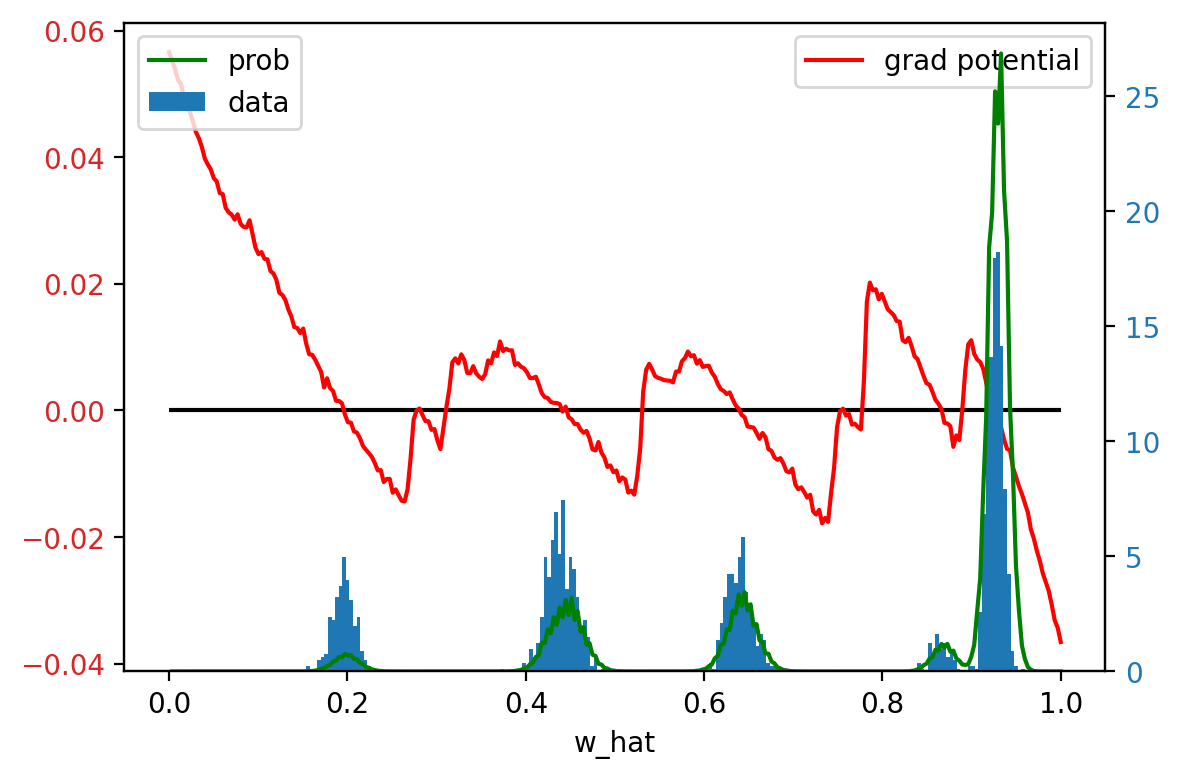

In [9]:
proj_data =torch.mm(torch.tensor(data, device = device, dtype = dtype), V).cpu()/myRBM.Nv**0.5
fig, ax1 = plt.subplots(dpi = 200)

color = 'tab:red'
ax1.set_xlabel("w_hat")
ax1.plot(w_hat_b,newy-w_hat_b,color='red', label = "grad potential")
ax1.hlines(0,0,1, color = 'black')
#ax1.scatter(proj_gen[:,0], proj_gen[:,1],alpha=0.2, label = 'data_gen')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
rdm_y = torch.randn(proj_data[:,0].shape)/20
ax2.hist(proj_data[:,0].numpy(), label = 'data', density=True, bins=200)
ax2.plot(w_hat_b[1:], p_m, color = "green", label = "prob")

ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax1.legend()
ax2.legend()
plt.show()

(0.0, 1.0)

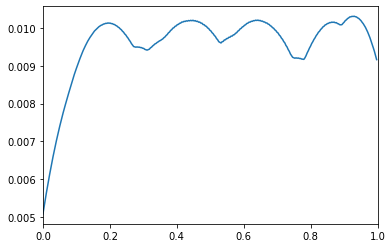

In [10]:
plt.plot( w_hat_b[:-1],potential)
plt.xlim(0,1)

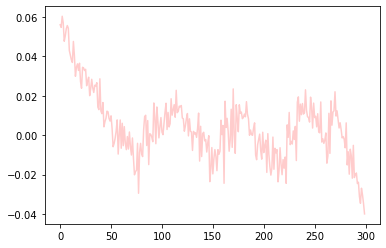

In [11]:
newyy = np.zeros((nb_point, nb_chain))
for i in range(nb_point):
    for j in range(newyy.shape[1]):
        newyy[i,j] = y[i*nb_chain+j]
for i in range(nb_chain):
    newyy[:,i]-=w_hat_b
plt.plot(newyy[:,0], color = 'red', alpha = .2)
plt.show()

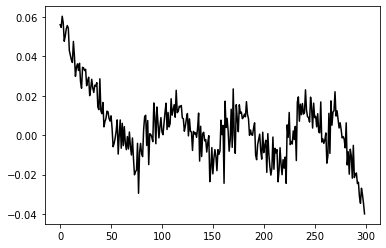

(300,)


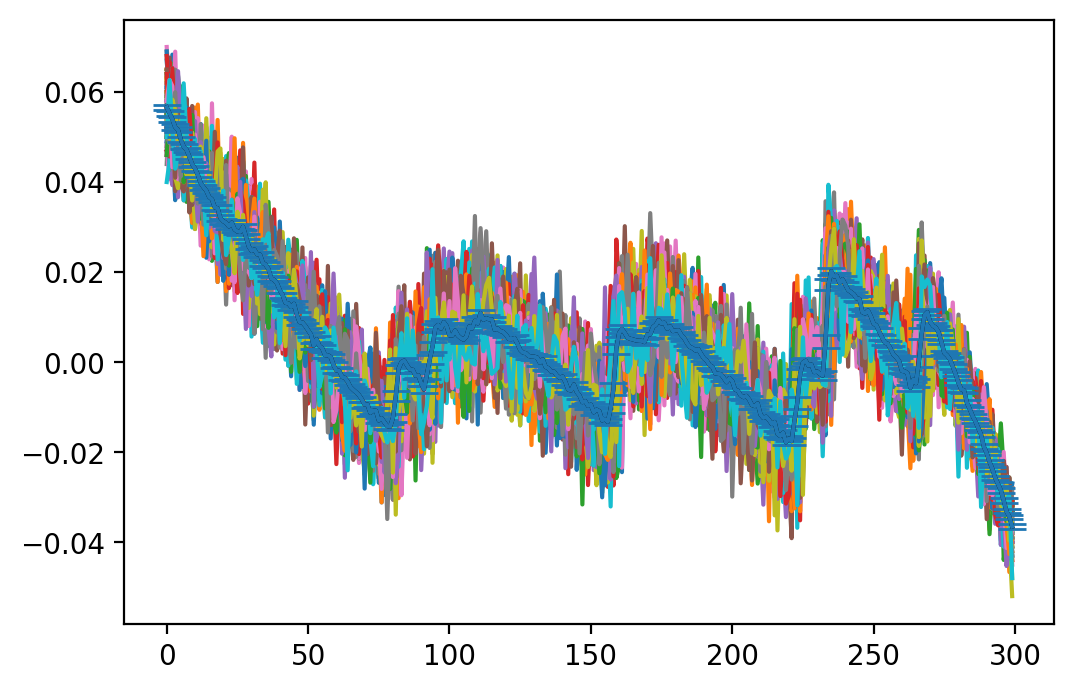

In [12]:
tmp = torch.mm(vtab[:,:,-25].T.cuda(), V0.unsqueeze(1)).cpu().numpy()
tmp2 = np.zeros((nb_point,nb_chain))
for i in range(nb_point):
    for j in range(nb_chain):
        tmp2[i,j] = y[nb_chain*i+j]

        
xx = stats.sem(tmp2,axis = 1)
plt.plot(tmp2[:,0]-w_hat_b, color = 'black')
plt.show()
plt.figure(dpi = 200)
plt.plot(newyy)
print(xx.shape)
x=[i for i in range(len(newy))]
plt.errorbar(x,newy-w_hat_b, yerr=xx,capsize=5)
plt.plot(newy-w_hat_b, color = 'black')

0.06688963


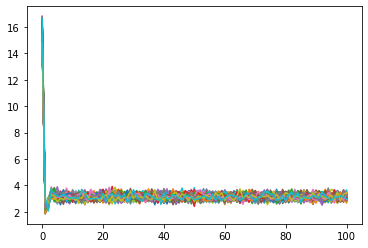

0.10033445


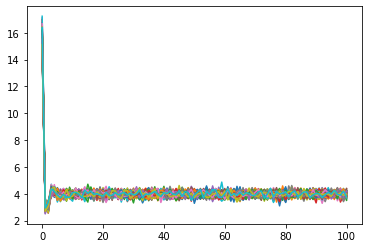

0.13377926


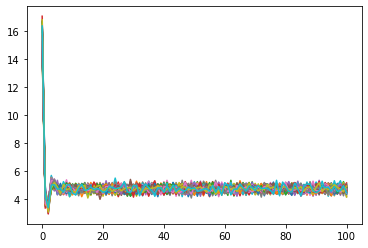

0.16722408


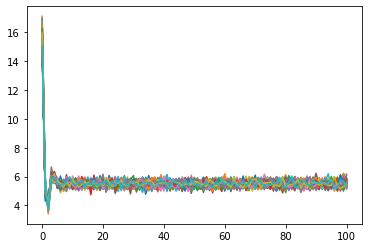

0.2006689


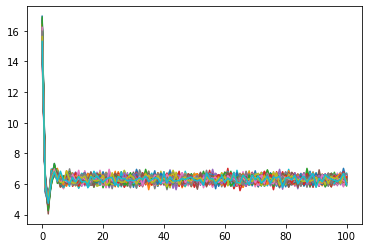

0.23411371


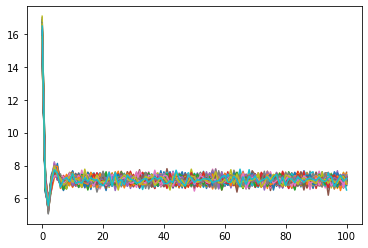

0.26755852


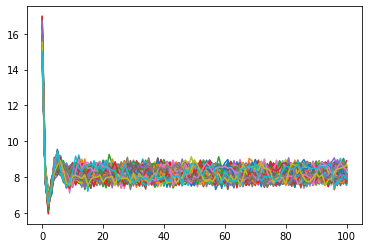

0.30100334


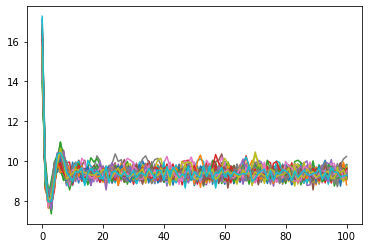

0.33444816


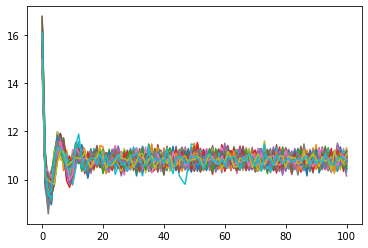

0.36789298


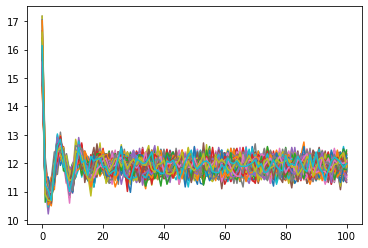

0.4013378


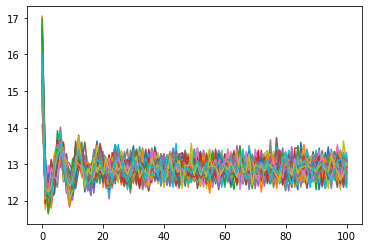

0.4347826


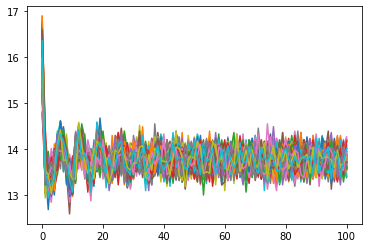

0.46822742


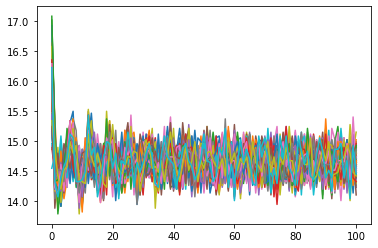

0.50167227


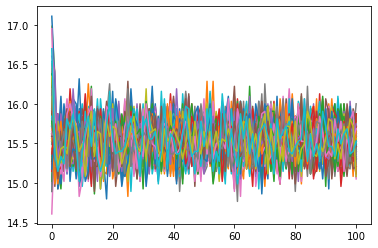

0.5351171


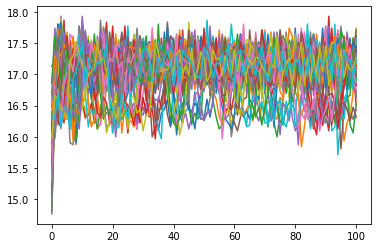

0.56856185


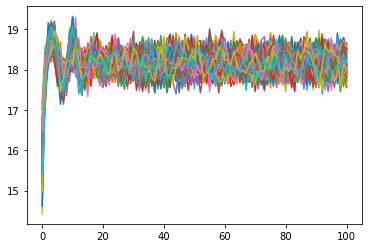

0.6020067


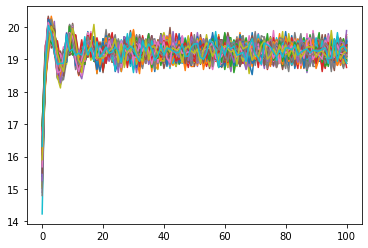

0.6354515


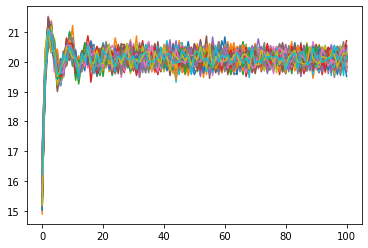

0.6688963


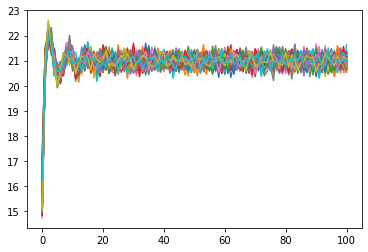

0.70234114


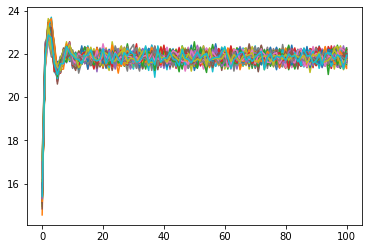

0.73578596


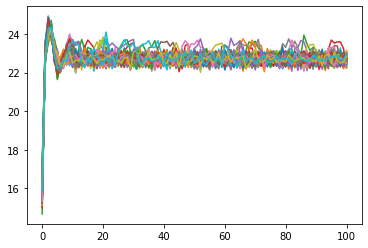

0.7692308


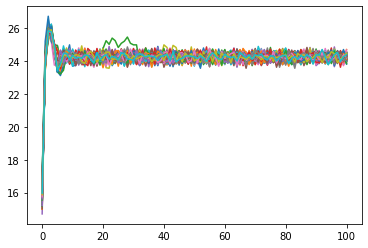

0.8026756


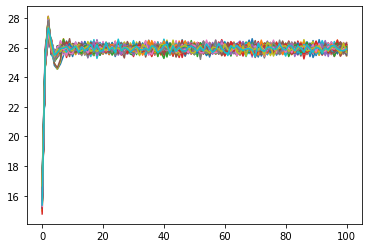

0.8361204


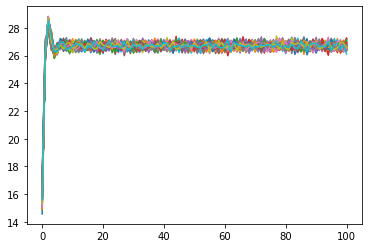

0.8695652


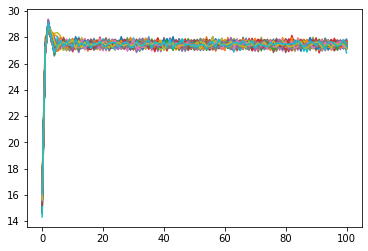

0.90301


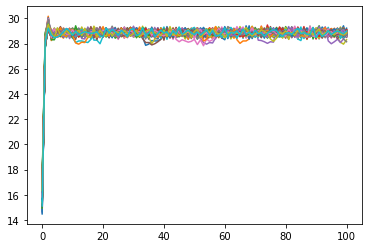

0.93645483


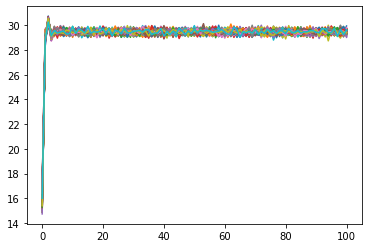

0.96989965


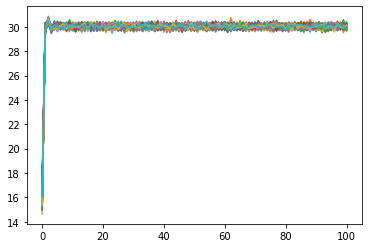

In [15]:
it_view = 70
for it_view in range(20,300,10):
    for i in range(nb_chain):
        proj_new = torch.mm(vtab[:,it_view*nb_chain+i,:].T.cuda(), V0.unsqueeze(1))
        plt.plot(proj_new.cpu())
    print(w_hat[it_view*nb_chain])

    plt.show()

0.020066889
0.020066889
0.020066889
0.020066889
0.020066889
0.020066889
0.020066889
0.020066889
0.020066889
0.020066889


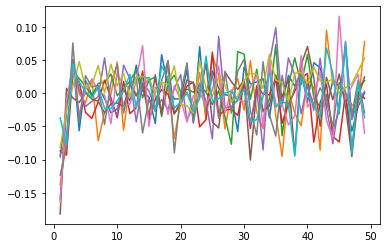

In [14]:
for i in range(10):
    proj_new = torch.mm(vtab[:,600+i,:].T.cuda(), V0.unsqueeze(1))
    print(w_hat[600+i])
    mea=proj_new[:,0].cpu()
    NN=len(mea)
    
    mea-=np.average(mea[int(0.9*NN):])


    xx=range(1,50)
    C=[torch.mean((mea[t:]*mea[:-t])) for t in xx]
    plt.plot(xx, C)
plt.show()